<a href="https://colab.research.google.com/github/LakshayDhiman023/ML/blob/master/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1: Install Dependencies and Set Environment
%%capture
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'  # Enable deterministic CUDA algorithms
# !pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install numpy matplotlib pillow tqdm opencv-python pycocotools
# Upgrade torch to match torchaudio
!pip install torch==2.6.0+cu124 torchvision==0.17.0+cu124 torchaudio==2.6.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html



In [3]:
# Cell 2: Import Libraries and Set Device Configuration
import os
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from google.colab import drive
from tqdm import tqdm

# Set environment variable for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set PyTorch configurations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Check CUDA availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")
output_dir = '/content/drive/MyDrive/ml_training/davis_output'
os.makedirs(output_dir, exist_ok=True)

CUDA is not available. Using CPU.


In [4]:
class DAVISDataset(Dataset):
    def __init__(self, davis_root, split='train', transform=None, subset_size=None, max_images_per_category=None, subset_seed=42):
        self.davis_root = davis_root
        self.transform = transform
        self.split = split

        # Read split file
        split_file = os.path.join(davis_root, 'ImageSets', '2017', f'{split}.txt')
        with open(split_file, 'r') as f:
            all_categories = [line.strip() for line in f if line.strip()]

        # Select subset of categories if specified
        if subset_size is not None and subset_size < len(all_categories):
            random.seed(subset_seed)
            self.categories = random.sample(all_categories, subset_size)
        else:
            self.categories = all_categories

        self.images = []
        self.targets = []

        # Load all images and annotations
        for category in self.categories:
            img_dir = os.path.join(davis_root, 'JPEGImages', '480p', category)
            ann_dir = os.path.join(davis_root, 'Annotations', '480p', category)

            img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

            if max_images_per_category is not None and max_images_per_category < len(img_files):
                random.seed(subset_seed + hash(category))
                img_files = random.sample(img_files, max_images_per_category)

            for img_file in img_files:
                img_path = os.path.join(img_dir, img_file)
                ann_file = img_file.replace('.jpg', '.png')
                ann_path = os.path.join(ann_dir, ann_file)

                if os.path.exists(ann_path):
                    self.images.append(img_path)
                    self.targets.append(ann_path)

        print(f'Loaded {len(self.images)} images from {len(self.categories)}/{len(all_categories)} categories for {split} split')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target_path = self.targets[idx]

        img = Image.open(img_path).convert("RGB")
        mask = np.array(Image.open(target_path))

        unique_colors = np.unique(mask)
        unique_colors = unique_colors[unique_colors > 0]

        boxes = []
        labels = []

        for color in unique_colors:
            binary_mask = (mask == color).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                boxes.append([x, y, x + w, y + h])
                labels.append(int(color))

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        # Debugging: Print unique labels
        print(f"Unique labels in the current image: {labels}")
        # Ensure labels are within valid range
        assert torch.all(labels < num_classes), "Labels exceed number of classes"
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

In [5]:
def build_frcnn_model(num_classes, use_fpn=True):
    if use_fpn:
        backbone = resnet_fpn_backbone('resnet50', pretrained=False)
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2
        )
        # Update anchor sizes and aspect ratios to match FPN feature maps
        anchor_generator = AnchorGenerator(
            sizes=((32,), (64,), (128,), (256,), (512,)),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )
    else:
        backbone = torchvision.models.resnet50(pretrained=False)
        backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
        backbone.out_channels = 2048
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        # Update anchor sizes and aspect ratios for single feature map
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

In [ ]:
# !pip uninstall numpy
!pip install numpy==1.26.4

In [6]:
import numpy as np
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, targets in tqdm(data_loader):
        # Convert images to tensors and move to device
        images = [torchvision.transforms.functional.to_tensor(image).to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            # Convert images to tensors before moving to device
            images = [T.ToTensor()(image).to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions from the model
            predictions = model(images)

            # Calculate loss manually if needed (example)
            # Here, we assume you have a function to calculate loss from predictions
            # loss_dict = calculate_loss(predictions, targets)
            # losses = sum(loss for loss in loss_dict.values())
            # total_loss += losses.item()

            # For now, just print predictions for debugging
            print(f"Predictions: {predictions}")

    return total_loss / len(data_loader)


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Training parameters
davis_root = '/content/drive/MyDrive/ml_project/DAVIS'
num_classes = 1000  # Background + Object

# Debugging: Print number of classes
print(f"Number of classes (including background): {num_classes}")
batch_size = 2
num_workers = 2
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
num_epochs = 10
subset_size = 5
max_images_per_category = 10
use_fpn = True

Using device: cpu
Number of classes (including background): 1000


In [8]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    img, target = dataset[idx]
    img = T.ToTensor()(img).to(device)
    with torch.no_grad():
        prediction = model([img])

    # Convert image for display
    img = img.permute(1, 2, 0).cpu().numpy()

    # Plot original image with ground truth boxes
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Ground Truth')
    for box in target['boxes']:
        box = box.cpu().numpy()
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]),
                                        box[2] - box[0],
                                        box[3] - box[1],
                                        fill=False,
                                        color='red'))

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title('Predictions')
    for box, score in zip(prediction[0]['boxes'], prediction[0]['scores']):
        if score > 0.5:  # Only show predictions with confidence > 0.5
            box = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]),
                                            box[2] - box[0],
                                            box[3] - box[1],
                                            fill=False,
                                            color='blue'))
    plt.show()

Phase 1: Training on subset...
Loaded 50 images from 5/60 categories for train split
Subset Epoch 1


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Subset Loss: 2.4116
Subset Epoch 2


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Subset Loss: 0.3927

Evaluating on subset...


  4%|▍         | 1/25 [00:00<00:12,  1.93it/s]

Predictions: [{'boxes': tensor([[520.3609,   8.0756, 815.9108, 310.9480],
        [148.0027,   0.0000, 711.4292, 369.2751],
        [251.5794,   0.0000, 491.3481, 386.9145],
        [352.0623,   0.0000, 616.4775, 406.4729],
        [137.0361,   0.0000, 425.5863, 373.6714],
        [195.7167,   0.0000, 596.2190, 247.6452],
        [  0.0000,  45.1297, 352.9175, 364.1960],
        [364.7351,   8.1537, 726.4924, 260.6329],
        [  0.0000,   0.0000, 477.2390, 246.1948],
        [ 58.6681, 153.0788, 568.8910, 404.1320],
        [273.9439,   0.0000, 853.9999, 173.3945],
        [543.6888,   0.0000, 737.9675, 474.3519],
        [327.8268,  68.6641, 823.5345, 444.5942],
        [  0.0000,   0.0000, 215.7529, 480.0000],
        [575.7042,  51.1064, 853.5973, 470.8707],
        [  0.0000, 187.2369, 377.4497, 480.0000],
        [177.0199, 162.1666, 806.2615, 389.1196],
        [534.8510,   2.2822, 797.1130, 136.2908],
        [769.8489,   0.0000, 845.7216, 322.5255],
        [180.0704,   0.000

  8%|▊         | 2/25 [00:00<00:09,  2.50it/s]

Predictions: [{'boxes': tensor([[  0.0000, 237.8978, 676.1299, 439.9565],
        [116.7521,   0.0000, 646.2579, 235.6554],
        [424.5013,  24.6000, 645.9456, 452.4759],
        [160.9178, 122.7667, 844.5565, 259.6614],
        [378.8629, 227.9408, 848.7825, 457.3694],
        [ 85.2289,  70.0792, 664.8068, 411.3875],
        [ 98.1684, 138.2108, 574.9523, 329.2436],
        [617.1083,   0.0000, 852.3519, 480.0000],
        [373.5825,  80.1766, 796.7498, 298.4276],
        [348.9652,  60.3022, 823.9868, 479.9596],
        [514.3781,   0.0000, 727.4677, 461.5988],
        [ 10.7849, 199.9984, 410.3393, 471.4389],
        [299.8407,   0.0000, 558.0147, 361.5701],
        [  0.0000, 326.3986, 775.8745, 476.6681],
        [ 51.3000,   0.0000, 853.9999, 336.4880],
        [  8.2570, 123.8795, 456.5295, 379.4467],
        [306.9981, 199.3596, 662.7404, 385.5256],
        [773.0745,  65.1741, 846.2040, 409.8872]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

 12%|█▏        | 3/25 [00:01<00:08,  2.74it/s]

Predictions: [{'boxes': tensor([[216.5705, 135.8005, 748.0710, 459.5931],
        [502.8979, 112.9211, 851.0302, 424.3051],
        [ 12.9081,  55.5682, 302.5149, 387.1099],
        [433.5649, 227.8441, 702.9009, 397.1916],
        [321.4645, 136.7865, 693.6064, 340.8851],
        [411.0914, 240.4421, 853.9999, 470.5400],
        [ 33.8947, 283.8636, 502.3637, 478.8022],
        [582.8950, 227.5657, 752.6323, 472.2057],
        [720.2211, 308.6530, 846.9983, 480.0000],
        [154.9748, 242.1784, 638.9949, 478.5175],
        [433.4783, 213.7910, 588.3959, 472.6492],
        [339.1765, 241.2660, 631.7990, 421.6168],
        [ 24.1081, 125.9918, 562.3223, 289.3810],
        [591.9446, 286.0407, 851.2405, 480.0000],
        [143.5964, 157.4238, 612.2166, 331.6756],
        [271.4301, 358.7593, 533.7756, 475.7487],
        [611.4451, 186.9942, 853.5804, 449.0155],
        [524.6664, 172.6293, 622.5917, 434.8185],
        [245.4916, 254.0334, 535.1479, 429.1404],
        [482.9909, 216.722

 16%|█▌        | 4/25 [00:01<00:07,  2.86it/s]

Predictions: [{'boxes': tensor([[205.4504,   0.0000, 481.8687, 476.5169],
        [  0.0000,  30.7754, 704.5850, 338.7947],
        [171.2756,   0.0000, 769.4530, 480.0000],
        [147.8374,   0.0000, 396.9029, 361.0898],
        [280.3571,  18.9523, 649.3549, 356.2450],
        [123.7397,   0.0000, 658.6839, 242.4541],
        [393.5613, 142.6156, 874.5705, 381.8600],
        [261.9026, 189.6307, 871.5938, 470.8401],
        [178.3717, 143.7265, 813.5609, 327.4143],
        [420.0684,  16.0367, 718.3901, 478.9554],
        [626.5865,  74.0213, 911.0000, 434.6354],
        [  0.0000,   0.0000, 364.5060, 409.0429],
        [559.5814, 210.4598, 911.0000, 473.2761],
        [156.5080, 189.0232, 682.6916, 391.9442],
        [560.2681,   0.0000, 789.8384, 478.3589],
        [511.5683,  65.2017, 879.7343, 321.1099],
        [  0.0000, 148.6966, 500.0435, 480.0000],
        [400.7426, 132.5362, 758.6946, 399.0617],
        [ 39.5810,  89.2647, 367.4371, 295.2856],
        [238.4926,   0.000

 20%|██        | 5/25 [00:01<00:06,  3.05it/s]

Predictions: [{'boxes': tensor([[276.8843,  71.4645, 750.3155, 287.6735],
        [310.0220,   0.0000, 608.5572, 394.2918],
        [104.5328,   0.0000, 403.4965, 377.1128],
        [207.2920,   0.0000, 691.9945, 207.5437],
        [  0.0000,   0.0000, 693.0489, 370.2737],
        [475.0921,   0.0000, 775.9377, 318.2687],
        [181.4299,  45.9209, 558.0182, 356.7746],
        [  0.0000,   0.0000, 219.9468, 416.3532],
        [237.0334,   0.0000, 457.1656, 441.4500],
        [ 63.0025,   0.0000, 529.0745, 224.3532],
        [411.4194,   0.0000, 667.9016, 478.8470],
        [  0.0000, 152.4940, 532.7797, 367.8800],
        [215.9309,   0.0000, 853.9999, 473.8061],
        [289.5953, 125.4275, 828.2305, 394.9550],
        [  0.0000, 116.5395, 382.4289, 476.4099],
        [636.1526,   0.0000, 853.9999, 469.0651]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3868, 0.3380, 0.2989, 0.2776, 0.2696, 0.2246, 0.2197

 24%|██▍       | 6/25 [00:02<00:06,  3.09it/s]

Predictions: [{'boxes': tensor([[157.8540,   0.0000, 716.2667, 337.5346],
        [  6.7121,   0.0000, 349.6386, 314.4387],
        [  5.0448,   0.0000, 620.4199, 236.3263],
        [199.2262, 134.3601, 673.7338, 373.1179],
        [337.9334,   0.0000, 634.1335, 446.9246],
        [523.0419,   2.7785, 739.9918, 424.1375],
        [223.4968,  10.8171, 563.3840, 266.2137],
        [230.2286, 229.8354, 797.9764, 462.9901],
        [226.1307,  64.6183, 509.4608, 413.9846],
        [289.4378,   0.0000, 790.9319, 196.3086],
        [570.6673, 142.3604, 853.9999, 440.3478],
        [430.6607,  10.6467, 766.6843, 300.9702],
        [145.1823,   0.0000, 386.1686, 435.1840],
        [139.1140,  59.1188, 719.4901, 223.9094],
        [ 90.0219, 230.6337, 571.9131, 466.2591],
        [ 24.5976,  81.6045, 433.9761, 395.0193],
        [ 58.3259, 222.1783, 651.5925, 363.0265],
        [749.8308, 112.8573, 850.8040, 443.8719],
        [378.9362, 114.8907, 826.3181, 278.8074],
        [ 34.6395,  92.664

 28%|██▊       | 7/25 [00:02<00:05,  3.20it/s]

Predictions: [{'boxes': tensor([[175.4569,   0.0000, 592.1875, 361.1896],
        [ 16.1500,   0.0000, 746.5884, 242.3224],
        [278.4876,   0.0000, 825.3742, 388.2431],
        [394.1150,   0.0000, 685.8139, 480.0000],
        [561.1348, 138.7947, 882.1165, 473.7468],
        [ 73.2005,   0.0000, 723.0229, 472.1634],
        [657.4611,   0.0000, 911.0000, 384.5656],
        [  0.0000,   0.0000, 379.7580, 389.3433],
        [107.9226,  73.2940, 695.2909, 295.4332],
        [350.5221, 152.2241, 911.0000, 399.9226],
        [ 26.0483, 180.6777, 410.7361, 480.0000],
        [109.7679, 127.0827, 609.9409, 421.1290],
        [291.5531,   6.0424, 911.0000, 150.6977],
        [  0.0000, 253.7341, 667.1898, 449.9787],
        [805.2650,   0.0000, 900.8275, 262.4531],
        [520.8959,   0.0000, 737.1301, 480.0000],
        [450.4321,   0.0000, 852.9412, 215.0419],
        [  9.5055, 250.3828, 161.8029, 480.0000],
        [  0.0000,   0.0000, 234.9074, 129.7796],
        [265.5562, 227.448

 32%|███▏      | 8/25 [00:02<00:05,  3.17it/s]

Predictions: [{'boxes': tensor([[ 26.7899, 213.7696, 371.5617, 461.7235],
        [ 41.9856, 251.9472, 638.6487, 445.4467],
        [328.3146, 178.1382, 736.9836, 402.1201],
        [ 38.7323,   0.0000, 527.6239, 235.4075],
        [598.4716, 100.3431, 853.9999, 461.0664],
        [371.7395, 102.8619, 786.6841, 345.4428],
        [  0.0000, 170.0795, 582.5132, 365.5799],
        [123.8018,  40.4429, 726.8352, 246.7701],
        [189.7648, 112.0882, 849.6357, 446.6634],
        [ 46.5606, 332.5030, 852.9052, 474.6609],
        [389.9265,   0.0000, 772.0340, 472.5313],
        [407.4175,  59.0382, 852.3366, 263.7395],
        [238.3951,   0.9812, 446.2363, 475.9549],
        [  0.0000,   0.0000, 804.3889, 339.9035],
        [527.8218,   0.0000, 853.9999, 335.6477],
        [190.3634,   0.0000, 582.8726, 370.1596],
        [  0.0000,   0.0000, 406.1742, 372.5974],
        [ 14.5840, 362.6687, 463.6360, 480.0000],
        [400.6988, 250.3289, 853.9999, 475.4254],
        [ 46.3837, 121.112

 36%|███▌      | 9/25 [00:02<00:04,  3.24it/s]

Predictions: [{'boxes': tensor([[235.2094,  56.1136, 541.5729, 395.4635],
        [274.5321,   0.0000, 854.0850, 220.1891],
        [108.0038,   0.0000, 628.3787, 349.4699],
        [ 31.7966,   0.0000, 375.6281, 439.6864],
        [  0.0000,   0.0000, 841.0232, 439.6520],
        [391.5060,  20.4396, 657.1661, 477.7811],
        [393.8952, 149.3641, 818.4592, 438.8407],
        [210.5694,  55.1808, 835.9992, 340.0383],
        [173.0781,  32.3539, 457.2953, 480.0000],
        [ 15.6116,   0.0000, 628.9656, 178.4237],
        [301.4509, 249.7919, 911.0000, 480.0000],
        [605.5922,  11.4522, 905.6390, 368.6906],
        [277.6954,   0.0000, 529.4910, 138.2449],
        [576.3176,  84.6315, 822.7651, 473.1963],
        [629.3451, 160.1130, 911.0000, 446.5630],
        [298.6081,   0.0000, 514.9334, 147.8327],
        [ 11.2426, 176.9512, 907.1329, 383.5842],
        [115.6586, 123.5438, 634.1620, 447.6546],
        [204.4677,   6.7775, 699.6151, 122.4431],
        [270.9785,   0.000

 40%|████      | 10/25 [00:03<00:04,  3.23it/s]

Predictions: [{'boxes': tensor([[225.6771, 170.7896, 664.3837, 406.0365],
        [514.9273,   0.0000, 824.8087, 341.7588],
        [354.0550,  74.5893, 583.7258, 452.2491],
        [195.6559,  20.0531, 694.2537, 465.1732],
        [254.7810,   0.0000, 445.8038, 480.0000],
        [384.0268, 145.8343, 788.1010, 428.3275],
        [ 83.6916,   0.0000, 739.0398, 267.8943],
        [325.4890,   0.0000, 819.7166, 230.7589],
        [325.3415,  84.3400, 778.7011, 312.7718],
        [ 85.2708, 149.2137, 479.4676, 390.2567],
        [437.9859,   2.3553, 697.4382, 480.0000],
        [203.4285,  99.6501, 574.1813, 335.2647],
        [  0.0000,   0.0000, 488.6934, 234.6483],
        [ 33.4251,   0.0000, 247.2680, 480.0000],
        [173.7811,   0.0000, 368.2246, 480.0000],
        [614.9980,   0.0000, 853.9999, 477.6418],
        [  3.1375,  83.0777, 493.9959, 480.0000],
        [398.1694, 261.4901, 837.7006, 467.3686],
        [135.2266, 220.9285, 612.1157, 480.0000],
        [  0.0000,  56.667

 44%|████▍     | 11/25 [00:03<00:04,  3.30it/s]

Predictions: [{'boxes': tensor([[4.5390e+01, 0.0000e+00, 3.1217e+02, 3.4869e+02],
        [4.1011e+01, 0.0000e+00, 6.7056e+02, 2.8664e+02],
        [3.8808e+02, 0.0000e+00, 7.3783e+02, 3.2464e+02],
        [1.3513e+02, 0.0000e+00, 4.6119e+02, 4.1882e+02],
        [2.8457e+02, 0.0000e+00, 8.2011e+02, 4.5554e+02],
        [5.0279e+02, 0.0000e+00, 8.4671e+02, 3.0454e+02],
        [4.2207e+02, 1.0529e+02, 8.5036e+02, 3.5673e+02],
        [4.7344e+02, 2.6909e+01, 7.5554e+02, 4.6437e+02],
        [0.0000e+00, 3.4613e+01, 3.7221e+02, 4.6789e+02],
        [3.2897e+01, 9.7101e+01, 8.0903e+02, 3.8577e+02],
        [1.5720e+02, 4.5023e+01, 8.2338e+02, 2.4884e+02],
        [2.7953e+02, 0.0000e+00, 5.3190e+02, 1.2364e+02],
        [1.7828e+02, 1.3606e+00, 3.7497e+02, 1.7665e+02],
        [2.7438e+02, 0.0000e+00, 5.6555e+02, 1.0728e+02],
        [3.4981e+01, 1.6681e-01, 3.8643e+02, 1.4419e+02],
        [2.1463e+02, 4.0988e+01, 5.8751e+02, 3.9206e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 48%|████▊     | 12/25 [00:03<00:03,  3.28it/s]

Predictions: [{'boxes': tensor([[403.8644, 202.3167, 768.1896, 448.8664],
        [  0.0000,  32.5691, 478.9988, 391.7156],
        [ 49.2469,   0.0000, 301.2691, 399.8834],
        [110.5983,   0.0000, 488.7505, 284.1167],
        [215.0681,   0.0000, 853.9999, 168.1043],
        [ 94.8741,  99.5475, 545.3607, 339.5649],
        [217.3451,  71.2900, 713.0715, 279.1260],
        [314.1052,   0.0000, 662.3324, 393.2338],
        [103.3750,   0.0000, 853.9999, 352.2962],
        [108.4900, 182.0889, 853.9999, 467.7193],
        [ 80.3539, 340.6162, 682.4180, 475.2942],
        [  0.0000,  52.5739, 647.6783, 240.4654],
        [343.3256, 146.0380, 853.9999, 400.7743],
        [193.8229,   0.0000, 538.7865, 480.0000],
        [  6.2688, 226.0956, 381.2777, 480.0000],
        [520.9075,   0.0000, 812.6172, 410.7436],
        [209.7517, 237.9650, 699.8747, 448.8688],
        [581.2589, 135.0719, 853.9999, 432.7030],
        [394.2539,  31.8185, 852.2112, 313.9196],
        [271.5019, 324.542

 52%|█████▏    | 13/25 [00:04<00:03,  3.33it/s]

Predictions: [{'boxes': tensor([[110.1251, 162.7949, 709.6298, 418.7694],
        [157.7455,   0.0000, 835.7769, 480.0000],
        [390.8748, 129.1058, 837.1690, 373.9283],
        [  9.1656,   0.0000, 632.1474, 188.8882],
        [299.0231, 131.7135, 589.6873, 458.6827],
        [436.9667,   0.0000, 699.9739, 363.5763],
        [141.8466, 112.0244, 460.4110, 470.3967],
        [531.6584,   0.0000, 830.7572, 448.9861],
        [232.2110,  60.1313, 747.9161, 327.2230],
        [331.6097,   0.0000, 852.3682, 229.4433],
        [380.2132,  43.5606, 642.2043, 480.0000],
        [145.9188, 257.7927, 709.0416, 474.3827],
        [162.4466,   0.0000, 527.7703, 273.0110],
        [233.1240,   0.0000, 414.2074, 480.0000],
        [  0.0000,   5.4960, 689.5179, 338.4060],
        [ 14.6211,   0.0000, 385.6824, 480.0000],
        [ 18.8951,  48.8829, 301.5761, 343.6746],
        [473.1812,  57.0135, 853.9999, 302.7119],
        [ 33.9098, 128.9160, 474.7963, 322.0100],
        [307.0497, 127.186

 56%|█████▌    | 14/25 [00:04<00:03,  3.30it/s]

Predictions: [{'boxes': tensor([[2.4493e+02, 0.0000e+00, 5.5705e+02, 4.8000e+02],
        [8.8305e+01, 0.0000e+00, 3.6009e+02, 3.0965e+02],
        [5.0748e+01, 0.0000e+00, 5.6782e+02, 2.1729e+02],
        [1.8223e+02, 8.0344e+01, 6.3300e+02, 3.8383e+02],
        [2.5892e+02, 1.3814e+02, 7.1600e+02, 3.0087e+02],
        [1.1291e+02, 2.1642e+02, 6.7002e+02, 4.4944e+02],
        [1.7538e+02, 0.0000e+00, 8.5400e+02, 2.0660e+02],
        [3.9699e+02, 4.5266e+01, 6.0881e+02, 4.7177e+02],
        [0.0000e+00, 0.0000e+00, 6.1143e+02, 4.3941e+02],
        [4.1689e+02, 7.9202e+01, 8.5385e+02, 4.3541e+02],
        [7.9159e+01, 6.2526e+01, 5.0544e+02, 2.7757e+02],
        [5.2334e+01, 1.4866e+02, 5.2482e+02, 3.5166e+02],
        [1.2017e+02, 0.0000e+00, 4.2846e+02, 4.8000e+02],
        [6.7341e-01, 2.4457e+02, 4.9734e+02, 4.7201e+02],
        [3.4678e+02, 7.2981e+01, 7.5295e+02, 3.4127e+02],
        [7.2977e+01, 5.6420e+01, 8.1421e+02, 3.1308e+02],
        [2.3219e+02, 2.7265e+02, 7.7701e+02, 4.8

 60%|██████    | 15/25 [00:04<00:02,  3.36it/s]

Predictions: [{'boxes': tensor([[3.1520e+02, 1.5156e+02, 8.1038e+02, 3.6560e+02],
        [2.0539e+02, 8.8382e+01, 6.9389e+02, 4.3317e+02],
        [1.8197e+01, 1.9267e+02, 6.5419e+02, 3.6064e+02],
        [4.6146e+02, 2.3087e+01, 7.0652e+02, 4.5372e+02],
        [5.3936e+02, 6.3220e+01, 7.6884e+02, 4.2134e+02],
        [9.2818e+01, 1.1676e+02, 6.5829e+02, 2.9743e+02],
        [3.2158e+02, 3.1961e+01, 5.2623e+02, 4.6545e+02],
        [0.0000e+00, 1.3073e+02, 8.5400e+02, 4.6825e+02],
        [1.8106e+01, 1.7991e+02, 4.9867e+02, 4.7544e+02],
        [3.4078e+02, 1.8457e+02, 7.6462e+02, 3.6165e+02],
        [5.2325e+02, 1.6834e+02, 8.4762e+02, 4.5886e+02],
        [3.0945e+02, 2.2188e+02, 8.5400e+02, 4.3019e+02],
        [1.2537e+02, 9.1010e+01, 3.5416e+02, 4.5137e+02],
        [3.7273e+02, 1.6679e+01, 6.2377e+02, 4.5978e+02],
        [6.6818e-01, 4.1550e+01, 7.9276e+02, 3.2702e+02],
        [2.4650e+02, 1.1655e+02, 8.5400e+02, 2.6227e+02],
        [1.9025e+02, 2.0290e+01, 4.1480e+02, 4.7

 64%|██████▍   | 16/25 [00:05<00:02,  3.33it/s]

Predictions: [{'boxes': tensor([[ 29.7794,   0.0000, 504.9404, 255.9515],
        [  0.0000,   0.0000, 244.5034, 392.0890],
        [201.1609,   0.0000, 634.1691, 376.1080],
        [154.7156, 130.0327, 793.9243, 318.8484],
        [ 87.8052,   0.0000, 385.6548, 417.8360],
        [163.7306, 239.2905, 840.3998, 425.1397],
        [190.7711,   0.0000, 803.6135, 200.5452],
        [256.7225, 203.3495, 608.7672, 465.4346],
        [ 26.5312,   0.0000, 347.4539, 204.8386],
        [ 45.2600,   0.0000, 505.0979, 127.3431],
        [145.2435,  53.5563, 757.6266, 480.0000],
        [191.6382,   0.0000, 393.3982, 159.6341],
        [215.6164,   0.0000, 385.1331, 159.9436],
        [427.1946,   0.0000, 771.8410, 445.0495],
        [ 42.6739, 187.8784, 621.8107, 395.3827],
        [ 53.8092,   0.0000, 467.8862, 125.0472],
        [302.2034,   2.2468, 371.1757,  70.0184],
        [ 31.6813,   0.0000, 305.3929, 200.5335],
        [157.5389, 307.0489, 777.5665, 474.8416],
        [305.3008,   0.000

 68%|██████▊   | 17/25 [00:05<00:02,  3.35it/s]

Predictions: [{'boxes': tensor([[309.3428,   0.0000, 572.6850, 376.4008],
        [462.6652,   0.0000, 713.0772, 463.7419],
        [147.3290,   0.0000, 732.7925, 333.1951],
        [377.5255,   0.0000, 833.8724, 286.2047],
        [  0.0000,   0.0000, 506.4226, 381.7571],
        [396.5910,   0.0000, 609.3463, 480.0000],
        [274.8972,  38.9721, 901.8636, 392.9796],
        [334.1985,  98.8905, 712.5871, 329.9641],
        [434.4268, 227.3711, 905.8030, 473.0268],
        [170.8474,  57.8628, 599.9444, 480.0000],
        [  0.0000,   0.0000, 585.8242, 206.0839],
        [619.4362,   0.0000, 871.6512, 428.4728],
        [ 43.2619,  18.6295, 350.0231, 480.0000],
        [294.1684, 169.1006, 795.2254, 476.0017],
        [566.1411,   0.0000, 814.9777, 262.0339],
        [428.6011,   0.0000, 785.0622, 136.9213],
        [803.7772, 185.0302, 901.0909, 480.0000],
        [  2.8004, 409.7471, 175.0139, 474.6409],
        [  0.0000, 198.2976, 585.8398, 447.0766],
        [686.5687, 209.885

 72%|███████▏  | 18/25 [00:05<00:02,  3.29it/s]

Predictions: [{'boxes': tensor([[355.7681, 100.8301, 794.5253, 390.0511],
        [ 17.8329, 172.1967, 575.5953, 370.5464],
        [ 71.3483,   0.0000, 657.8463, 234.0376],
        [ 33.8584, 245.1926, 571.8926, 437.5646],
        [394.2036, 216.1778, 846.9880, 426.7870],
        [259.7919,  79.7371, 735.2527, 290.7369],
        [550.9183,  22.3872, 759.2993, 475.9172],
        [  0.0000, 121.2427, 716.4927, 448.2429],
        [  7.6826, 143.9451, 340.2248, 468.6206],
        [433.4683,   0.0000, 669.9008, 454.3393],
        [589.0208,  77.6488, 853.3533, 405.1398],
        [133.2164,   0.0000, 799.3267, 385.7202],
        [ 86.0684, 293.0855, 725.9424, 473.9929],
        [ 31.2002, 108.9578, 521.1357, 297.2701],
        [  0.0000,   5.5422, 395.3761, 318.1919],
        [449.5036,  77.2759, 846.2955, 303.7658],
        [177.7863, 194.4968, 779.1531, 375.5797],
        [418.6781,   0.0000, 767.2766, 264.7133],
        [207.1003,   0.0000, 524.7042, 465.7696]], device='cuda:0'), 'labels

 76%|███████▌  | 19/25 [00:05<00:01,  3.33it/s]

Predictions: [{'boxes': tensor([[ 97.8171,   0.0000, 393.0319, 393.5933],
        [ 14.0339,   0.0000, 470.8171, 250.3599],
        [165.0496,   0.0000, 755.4631, 187.3540],
        [ 32.7543,   0.0000, 688.8387, 349.4409],
        [318.2393,   0.0000, 808.0234, 391.7067],
        [251.4295,   0.0000, 546.8408, 412.1826],
        [  0.0000,   0.0000, 279.8492, 480.0000],
        [555.7954,   0.0000, 853.9999, 323.2885],
        [397.9204,   0.0000, 622.7285, 480.0000],
        [136.9434,   0.0000, 347.8987, 128.1573],
        [453.0852,  45.3532, 756.3591, 480.0000],
        [301.5714, 143.4053, 839.1860, 321.2378],
        [  4.2967, 104.0124, 545.0663, 422.2854],
        [153.0659,  22.7103, 278.5782, 203.7811]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3346, 0.2859, 0.2628, 0.2021, 0.1903, 0.1205, 0.1165, 0.1057, 0.0995,
        0.0682, 0.0643, 0.0617, 0.0593, 0.0575], device='cuda:0')}, {'boxes': tensor([[2

 80%|████████  | 20/25 [00:06<00:01,  3.31it/s]

Predictions: [{'boxes': tensor([[230.8922,  68.9505, 502.1952, 453.1011],
        [  0.0000,   0.0000, 749.6189, 355.3689],
        [268.2411,  26.8825, 651.7537, 382.4714],
        [  0.0000,  25.3527, 366.0613, 333.6480],
        [135.9911, 132.0320, 580.2635, 387.4832],
        [261.6717,   0.0000, 863.4380, 239.8482],
        [106.3348,   0.0000, 437.4456, 480.0000],
        [167.9572,   0.0000, 520.4738, 321.0593],
        [266.0430,  43.6482, 911.0000, 480.0000],
        [334.9409, 139.4539, 799.6846, 424.3752],
        [385.4851,   0.0000, 716.4022, 480.0000],
        [582.3344,   0.0000, 892.1729, 480.0000],
        [509.6472,  22.7815, 875.8458, 306.4811],
        [ 40.8873, 187.3469, 520.3539, 480.0000],
        [ 10.4608,  51.1190, 408.5386, 301.7919],
        [425.8590, 122.0376, 848.1235, 341.4631],
        [196.8807,   5.6732, 604.0880, 165.9884],
        [  3.0102, 420.1707, 116.8309, 475.2928],
        [451.8624, 154.3445, 704.8934, 427.9030],
        [742.1036,  99.947

 84%|████████▍ | 21/25 [00:06<00:01,  3.36it/s]

Predictions: [{'boxes': tensor([[125.4967,   0.0000, 783.6320, 480.0000],
        [163.9201,   0.0000, 653.6468, 315.9860],
        [ 73.8946,   0.0000, 478.4448, 373.8618],
        [158.2081,  48.9198, 416.3754, 480.0000],
        [193.5677, 145.8687, 897.2745, 348.7426],
        [420.7697,   0.0000, 687.3990, 480.0000],
        [365.0029,   0.0000, 796.7086, 290.7629],
        [136.7174, 145.4011, 625.7535, 405.2440],
        [227.6954, 176.9177, 871.0859, 480.0000],
        [567.6562, 110.4099, 903.7225, 439.9719],
        [317.5652,  72.3736, 737.5247, 367.0027],
        [ 45.1266,   0.0000, 309.0323, 432.1130],
        [292.7951,  73.6652, 574.5934, 475.2482],
        [ 43.3532,  98.5979, 370.1943, 254.9699],
        [  0.0000, 233.2757, 461.3666, 480.0000],
        [516.8918,  30.7419, 878.4557, 313.1305],
        [425.9885, 192.2633, 770.6318, 373.6829],
        [796.4236, 131.1139, 899.2482, 480.0000],
        [473.3507, 245.3440, 911.0000, 480.0000],
        [  0.0000, 312.774

 88%|████████▊ | 22/25 [00:06<00:00,  3.26it/s]

Predictions: [{'boxes': tensor([[1.1371e+02, 1.1541e+00, 4.1407e+02, 4.3752e+02],
        [1.4183e+02, 7.3147e+01, 6.1283e+02, 4.3113e+02],
        [2.3671e+02, 0.0000e+00, 5.1896e+02, 4.8000e+02],
        [4.7452e+02, 2.0555e+02, 8.8642e+02, 4.5234e+02],
        [1.5362e+02, 1.5688e+02, 7.8636e+02, 3.7890e+02],
        [2.1841e+02, 0.0000e+00, 7.9432e+02, 2.1219e+02],
        [3.5773e+02, 0.0000e+00, 6.3470e+02, 4.8000e+02],
        [9.4515e+00, 0.0000e+00, 7.9047e+02, 3.4414e+02],
        [0.0000e+00, 0.0000e+00, 5.3605e+02, 2.4212e+02],
        [0.0000e+00, 9.3643e+01, 5.1440e+02, 3.5026e+02],
        [2.2638e+02, 2.6991e+02, 7.2957e+02, 4.7317e+02],
        [3.3856e+02, 1.4357e+02, 8.1914e+02, 4.8000e+02],
        [0.0000e+00, 1.8497e+02, 7.0859e+02, 4.8000e+02],
        [0.0000e+00, 0.0000e+00, 2.4829e+02, 4.7346e+02],
        [5.8428e+02, 9.9203e+01, 9.1100e+02, 4.8000e+02],
        [4.0982e+02, 1.3587e+02, 9.1100e+02, 3.4723e+02],
        [3.1958e+02, 4.2431e+01, 7.4305e+02, 3.4

 92%|█████████▏| 23/25 [00:07<00:00,  3.30it/s]

Predictions: [{'boxes': tensor([[199.4788, 108.9531, 830.5098, 376.7442],
        [110.8183,   0.0000, 352.3095, 436.0749],
        [419.1518, 117.0374, 853.9999, 468.3977],
        [ 29.0885,   0.0000, 388.7299, 280.7004],
        [112.1403, 103.6595, 552.0662, 287.6422],
        [320.8351, 140.1449, 776.4818, 289.1830],
        [ 51.2638, 225.6200, 688.4007, 467.7206],
        [217.3764,  43.6292, 442.3911, 457.6678],
        [ 95.9545,   0.0000, 618.1998, 439.1435],
        [  0.0000,   0.0000, 274.1742, 415.6978],
        [  0.0000,   0.0000, 608.8610, 208.8547],
        [ 49.8885, 161.1640, 535.6620, 379.9549],
        [  9.5960, 176.3725, 402.1333, 480.0000],
        [201.0278, 295.6757, 815.1561, 480.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2282, 0.1911, 0.1733, 0.1259, 0.1013, 0.0927, 0.0891, 0.0821, 0.0771,
        0.0690, 0.0653, 0.0628, 0.0577, 0.0508], device='cuda:0')}, {'boxes': tensor([[0

 96%|█████████▌| 24/25 [00:07<00:00,  3.26it/s]

Predictions: [{'boxes': tensor([[2.0221e+02, 2.1134e+02, 8.2076e+02, 3.7757e+02],
        [1.7932e+02, 1.0491e+02, 7.9039e+02, 4.2993e+02],
        [3.3271e+02, 3.2690e+01, 5.3151e+02, 4.5786e+02],
        [3.1859e+02, 0.0000e+00, 7.0645e+02, 4.7142e+02],
        [2.5653e+01, 1.3449e+02, 6.4795e+02, 3.8444e+02],
        [7.7551e+01, 2.8186e+00, 5.8897e+02, 2.0987e+02],
        [4.7211e+02, 7.2294e+01, 8.3681e+02, 3.1794e+02],
        [2.5866e+02, 5.5246e+00, 4.4964e+02, 4.6644e+02],
        [0.0000e+00, 0.0000e+00, 4.2650e+02, 3.3276e+02],
        [0.0000e+00, 0.0000e+00, 2.1997e+02, 4.8000e+02],
        [3.8797e+02, 0.0000e+00, 8.5400e+02, 2.3608e+02],
        [5.0512e+02, 0.0000e+00, 7.6238e+02, 4.2656e+02],
        [1.1741e+02, 0.0000e+00, 5.5063e+02, 3.9707e+02],
        [1.8230e+02, 1.0896e+02, 5.3288e+02, 3.4852e+02],
        [1.7283e+02, 5.0454e+01, 6.4465e+02, 2.5239e+02],
        [9.7374e+01, 7.8009e+01, 3.7334e+02, 4.8000e+02],
        [6.6369e+02, 0.0000e+00, 8.5400e+02, 4.6

100%|██████████| 25/25 [00:07<00:00,  3.16it/s]

Predictions: [{'boxes': tensor([[148.3907,   0.0000, 775.4195, 230.4914],
        [464.3695, 198.0162, 853.9999, 460.0293],
        [220.5917, 140.4443, 843.2930, 468.1465],
        [ 85.1185, 239.1299, 574.7213, 465.9036],
        [324.2148, 147.3832, 789.8500, 342.6136],
        [254.5641, 291.8561, 791.6628, 480.0000],
        [158.3129, 163.5423, 560.0789, 365.4854],
        [132.3068, 105.8450, 817.5754, 284.3375],
        [206.0099,   0.0000, 579.5831, 320.8333],
        [  5.8325,  95.6493, 637.7408, 461.3411],
        [316.1422,  12.0850, 667.8772, 382.2274]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1158, 0.1109, 0.1028, 0.0959, 0.0913, 0.0855, 0.0769, 0.0710, 0.0688,
        0.0532, 0.0528], device='cuda:0')}, {'boxes': tensor([[232.9923, 254.5470, 715.4338, 467.3674],
        [ 23.6403, 218.8078, 555.4218, 430.6667],
        [114.9215, 286.3434, 581.4075, 475.5639],
        [437.4561, 235.7684, 853.9999, 473.

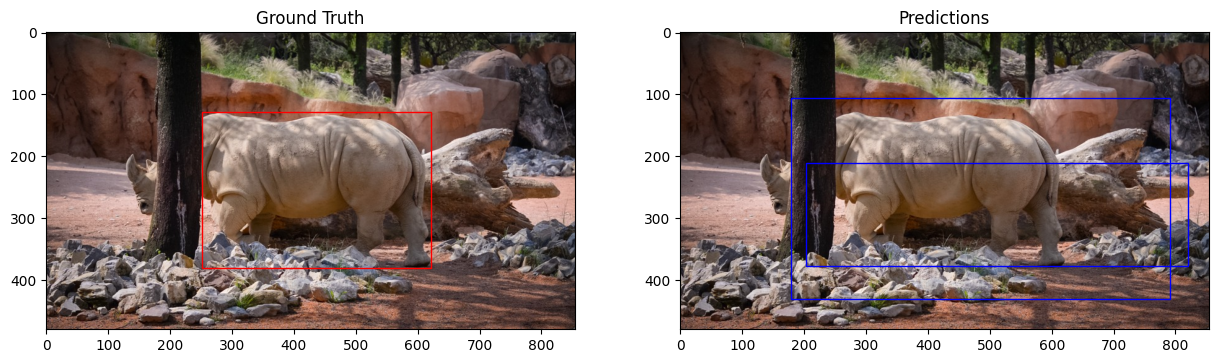

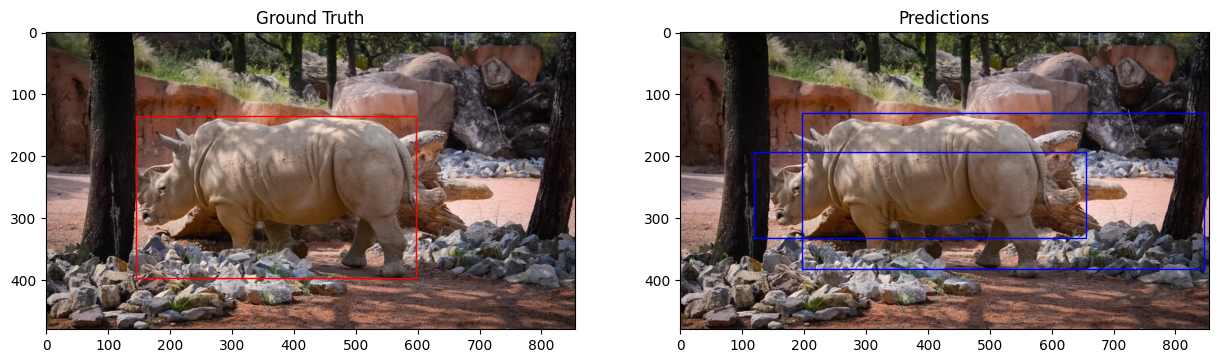

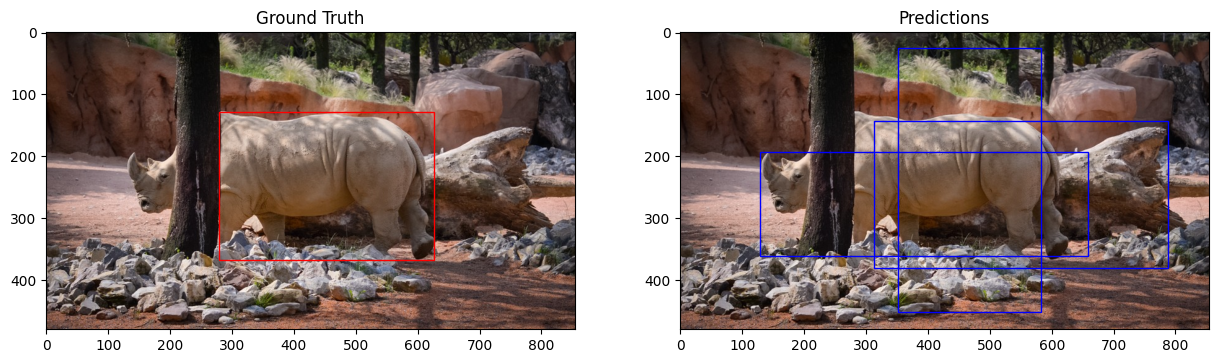

In [ ]:
# Phase 1: Subset Training
print("Phase 1: Training on subset...")

# Create subset dataset
subset_dataset = DAVISDataset(
    davis_root=davis_root,
    split='train',
    subset_size=subset_size,
    max_images_per_category=max_images_per_category
)

subset_loader = torch.utils.data.DataLoader(
    subset_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

# Initialize model and optimizer for subset training
model = build_frcnn_model(num_classes, use_fpn=use_fpn)
model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
)

# Train on subset
subset_losses = []
for epoch in range(2):  # Fewer epochs for subset training
    print(f"Subset Epoch {epoch+1}")
    loss = train_one_epoch(model, optimizer, subset_loader, device)
    subset_losses.append(loss)
    print(f"Subset Loss: {loss:.4f}")

# Save subset model
subset_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'subset_losses': subset_losses
}
torch.save(subset_checkpoint, os.path.join(output_dir, 'subset_checkpoint.pth'))

# Evaluate on subset
print("\nEvaluating on subset...")
subset_val_loss = evaluate(model, subset_loader, device)
print(f"Subset Validation Loss: {subset_val_loss:.4f}")

# Visualize subset predictions
print("\nVisualizing subset predictions...")
for i in range(3):  # Show 3 examples
    visualize_prediction(model, subset_dataset, i)

# Decision to proceed with full dataset training
proceed = input("Do you want to proceed with full dataset training? (yes/no): ")
if proceed.lower() != 'yes':
    print("Training stopped after subset evaluation.")
    exit()


In [9]:
print("\nPhase 2: Training on full dataset...")

# Create full dataset
full_dataset = DAVISDataset(davis_root=davis_root, split='train')
full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

# Initialize a new model with fresh weights
model = build_frcnn_model(num_classes, use_fpn=use_fpn)
model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
)

# Train on full dataset
full_losses = []
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Full Dataset Epoch {epoch+1}")
    loss = train_one_epoch(model, optimizer, full_loader, device)
    full_losses.append(loss)
    print(f"Full Dataset Loss: {loss:.4f}")

    # Save best model
    if loss < best_loss:
        best_loss = loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join(output_dir, 'best_model.pth'))

# Cell 10: Plot Training Progress
plt.figure(figsize=(10, 5))
plt.plot(subset_losses, label='Subset Training')
plt.plot(range(len(subset_losses), len(subset_losses) + len(full_losses)), full_losses, label='Full Dataset Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Cell 11: Evaluation
print("\nEvaluating model...")

# Create validation dataset
val_dataset = DAVISDataset(davis_root=davis_root, split='val')
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

# Load best model
checkpoint = torch.load(os.path.join(output_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate
val_loss = evaluate(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}")

# Cell 12: Visualization Function
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    img, target = dataset[idx]

    with torch.no_grad():
        prediction = model([img.to(device)])

    # Convert image for display
    img = img.permute(1, 2, 0).cpu().numpy()

    # Plot original image with ground truth boxes
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Ground Truth')
    for box in target['boxes']:
        box = box.cpu().numpy()
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]),
                                        box[2] - box[0],
                                        box[3] - box[1],
                                        fill=False,
                                        color='red'))

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title('Predictions')
    for box, score in zip(prediction[0]['boxes'], prediction[0]['scores']):
        if score > 0.5:  # Only show predictions with confidence > 0.5
            box = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]),
                                            box[2] - box[0],
                                            box[3] - box[1],
                                            fill=False,
                                            color='blue'))
    plt.show()

# Visualize some predictions
print("\nVisualizing predictions...")
for i in range(3):  # Show 3 examples
    visualize_prediction(model, val_dataset, i)


Phase 2: Training on full dataset...
Loaded 4209 images from 60/60 categories for train split


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Full Dataset Epoch 1


  0%|          | 0/2105 [00:00<?, ?it/s]

Unique labels in the current image: tensor([1, 2])Unique labels in the current image: tensor([1, 4])

Unique labels in the current image: tensor([1])
Unique labels in the current image: tensor([1])
Unique labels in the current image: tensor([1, 2])
Unique labels in the current image: tensor([1, 2])
Unique labels in the current image: tensor([1, 2])
Unique labels in the current image: tensor([1])
Unique labels in the current image: tensor([1, 2, 3, 4, 5])
Unique labels in the current image: tensor([1, 2, 3])


  0%|          | 1/2105 [00:59<34:58:49, 59.85s/it]

Unique labels in the current image: tensor([1, 2, 3])
Unique labels in the current image: tensor([1, 2, 3])


  0%|          | 2/2105 [01:55<33:22:42, 57.14s/it]

Unique labels in the current image: tensor([1])
Unique labels in the current image: tensor([1, 2, 3])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1a3c092840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
     

KeyboardInterrupt: 